In [1]:
import keras
from keras import backend as K
from keras.layers import Dense, Input
import numpy as np
import tensorflow as tf
import math
import h5py
import random
import time
import pandas as pd
from context import * # imports MDN
import matplotlib.pyplot as plt
%matplotlib inline

input_colour = 'darkblue'
gen_colour = 'firebrick'
plt.style.use('seaborn-talk')

Using TensorFlow backend.


In [2]:
# Only for GPU use:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

## Helper functions for touchscreen performances

We need a few helper functions for managing performances:
    
- Convert performances to and from pandas dataframes.
- Generate random touches.
- Sample whole performances from scratch and from a priming performance.
- Plot performances including dividing into swipes.

In [3]:
SCALE_FACTOR = 10  # scales input and output from the model. Should be the same between training and inference.


def build_robojam_model(seq_len=30, hidden_units=256, num_mixtures=5, layers=2, time_dist=True, inference=False, compile_model=True, print_summary=True):
    """Builds a RoboJam MDRNN model for training or inference.
    
    Keyword Arguments:
    seq_len : 
    hidden_units : 
    num_mixtures : 
    layers : 
    time_dist : 
    inference : 
    compile_model : 
    print_summary : 
    """
    print("Building RoboJam Model...")
    out_dim = 3 # fixed in the model. x, t, dt, could add extra dim for moving/not moving
    # Set up training mode
    stateful = False
    batch_shape = None
    # Set up inference mode.
    if inference:
        stateful = True
        batch_shape = (1,1,out_dim)
    inputs = keras.layers.Input(shape=(seq_len,out_dim), name='inputs', batch_shape=batch_shape)
    lstm_in = inputs # starter input for lstm
    for layer_i in range(layers):
        ret_seq = True
        if (layer_i == layers - 1) and not time_dist:
            # return sequences false if last layer, and not time distributed.
            ret_seq = False
        lstm_out = keras.layers.LSTM(hidden_units, name='lstm'+str(layer_i), return_sequences=ret_seq, stateful=stateful)(lstm_in)
        lstm_in = lstm_out
    
    mdn_layer = mdn.MDN(out_dim, num_mixtures, name='mdn_outputs')
    if time_dist:
        mdn_layer = keras.layers.TimeDistributed(mdn_layer, name='td_mdn')
    mdn_out = mdn_layer(lstm_out)  # apply mdn
    model = keras.models.Model(inputs=inputs, outputs=mdn_out)
    
    if compile_model:
        loss_func = mdn.get_mixture_loss_func(out_dim,num_mixtures)
        optimizer = keras.optimizers.Adam() # keras.optimizers.Adam(lr=0.0001))
        model.compile(loss=loss_func, optimizer=optimizer)

    model.summary()
    return model


# Performance Helper Functions


def perf_df_to_array(perf_df):
    """Converts a dataframe of a performance into array a,b,dt format."""
    perf_df['dt'] = perf_df.time.diff()
    perf_df.dt = perf_df.dt.fillna(0.0)
    # Clean performance data
    # Tiny Performance bounds defined to be in [[0,1],[0,1]], edit to fix this.
    perf_df.at[perf_df[perf_df.dt > 5].index, 'dt'] = 5.0
    perf_df.at[perf_df[perf_df.dt < 0].index, 'dt'] = 0.0
    perf_df.at[perf_df[perf_df.x > 1].index, 'x'] = 1.0
    perf_df.at[perf_df[perf_df.x < 0].index, 'x'] = 0.0
    perf_df.at[perf_df[perf_df.y > 1].index, 'y'] = 1.0
    perf_df.at[perf_df[perf_df.y < 0].index, 'y'] = 0.0
    return np.array(perf_df[['x', 'y', 'dt']])


def perf_array_to_df(perf_array):
    """Converts an array of a performance (a,b,dt format) into a dataframe."""
    perf_array = perf_array.T
    perf_df = pd.DataFrame({'x': perf_array[0], 'y': perf_array[1], 'dt': perf_array[2]})
    perf_df['time'] = perf_df.dt.cumsum()
    perf_df['z'] = 38.0
    # As a rule of thumb, could classify taps with dt>0.1 as taps, dt<0.1 as moving touches.
    perf_df['moving'] = 1
    perf_df.at[perf_df[perf_df.dt > 0.1].index, 'moving'] = 0
    perf_df = perf_df.set_index(['time'])
    return perf_df[['x', 'y', 'z', 'moving']]


def random_touch():
    """Generate a random tiny performance touch."""
    return np.array([np.random.rand(), np.random.rand(), 0.01])


def constrain_touch(touch):
    """Constrain touch values from the MDRNN"""
    touch[0] = min(max(touch[0], 0.0), 1.0)  # x in [0,1]
    touch[1] = min(max(touch[1], 0.0), 1.0)  # y in [0,1]
    touch[2] = max(touch[2], 0.001)  # dt # define minimum time step
    return touch

def generate_random_tiny_performance(model, n_mixtures, first_touch, time_limit=5.0, steps_limit=1000, temp=1.0, sigma_temp=0.0):
    """Generates a tiny performance up to 5 seconds in length."""
    time = 0
    steps = 0
    previous_touch = first_touch
    performance = [previous_touch.reshape((3,))]
    while (steps < steps_limit and time < time_limit):
        params = model.predict(previous_touch.reshape(1,1,3) * SCALE_FACTOR)
        previous_touch = mdn.sample_from_output(params[0], 3, n_mixtures, temp=temp, sigma_temp=sigma_temp) / SCALE_FACTOR
        output_touch = previous_touch.reshape(3,)
        output_touch = constrain_touch(output_touch)
        performance.append(output_touch.reshape((3,)))
        steps += 1
        time += output_touch[2]
    return np.array(performance)


def condition_and_generate(model, perf, n_mixtures, time_limit=5.0, steps_limit=1000, temp=1.0, sigma_temp=0.0):
    """Conditions the network on an existing tiny performance, then generates a new one."""
    time = 0
    steps = 0
    # condition
    for touch in perf:
        params = model.predict(touch.reshape(1,1,3) * SCALE_FACTOR)
        previous_touch = mdn.sample_from_output(params[0], 3, n_mixtures, temp=temp, sigma_temp=sigma_temp) / SCALE_FACTOR
        output = [previous_touch.reshape((3,))]
    # generate
    while (steps < steps_limit and time < time_limit):
        params = model.predict(previous_touch.reshape(1,1,3) * SCALE_FACTOR)
        previous_touch = mdn.sample_from_output(params[0], 3, n_mixtures, temp=temp, sigma_temp=sigma_temp) / SCALE_FACTOR
        output_touch = previous_touch.reshape(3,)
        output_touch = constrain_touch(output_touch)
        output.append(output_touch.reshape((3,)))
        steps += 1
        time += output_touch[2]
    net_output = np.array(output)
    return net_output

def divide_performance_into_swipes(perf_df):
    """Divides a performance into a sequence of swipe dataframes for plotting."""
    touch_starts = perf_df[perf_df.moving == 0].index
    performance_swipes = []
    remainder = perf_df
    for att in touch_starts:
        swipe = remainder.iloc[remainder.index < att]
        performance_swipes.append(swipe)
        remainder = remainder.iloc[remainder.index >= att]
    performance_swipes.append(remainder)
    return performance_swipes

def plot_2D(perf_df, name="foo", saving=False):
    """Plot a 2D representation of a performance 2D"""
    swipes = divide_performance_into_swipes(perf_df)
    plt.figure(figsize=(8, 8))
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=gen_colour, linewidth=5.0)
    plt.ylim(1.0,0)
    plt.xlim(0,1.0)
    plt.xticks([])
    plt.yticks([])
    if saving:
        plt.savefig(name+".png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()
        
def plot_double_2d(perf1, perf2, name="foo", saving=False):
    """Plot two performances in 2D"""
    plt.figure(figsize=(8, 8))
    swipes = divide_performance_into_swipes(perf1)
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=input_colour, linewidth=5.0)
    swipes = divide_performance_into_swipes(perf2)
    for swipe in swipes:
        p = plt.plot(swipe.x, swipe.y, 'o-')
        plt.setp(p, color=gen_colour, linewidth=5.0)
    plt.ylim(1.0,0)
    plt.xlim(0,1.0)
    plt.xticks([])
    plt.yticks([])
    if saving:
        plt.savefig(name+".png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

# Load up the Dataset:

The dataset consists of around 1000 5-second performances from the MicroJam app.

This is in a sequence of points consisting of an x-location, a y-location, and a time-delta from the previous point.

When the user swipes, the time-delta is very small, if they tap it's quite large.

Let's have a look at some of the data:

In [4]:
### Test Loading from the saved datafile.
with np.load('../datasets/tiny_performance_datasets.npz') as loaded:
    loaded_raw = loaded['raw_perfs']
    loaded_diff = loaded['diff_perfs']
    
print("Loaded perfs:", len(loaded_raw), "and", len(loaded_diff))
print("Num touches:", np.sum([len(l) for l in loaded_raw]))

corpus = []

for l in loaded_raw:
    corpus.append(l[:,:-1])
    
    
# Plot a bit of the data to have a look:
plot_2D(perf_array_to_df(random.choice(corpus)))

Loaded perfs: 1394 and 1394
Num touches: 219582


# Define the RNN

In [23]:
# Model Hyperparameters
SEQ_LEN = 30
HIDDEN_UNITS = 512
N_LAYERS = 2
NUMBER_MIXTURES = 5
TIME_DIST = True

# Training Hyperparameters:
BATCH_SIZE = 64
EPOCHS = 100
VAL_SPLIT=0.10

# Set random seed for reproducibility
SEED = 2345  
random.seed(SEED)
np.random.seed(SEED)

def batch_generator(seq_len, batch_size, dim, corpus):
    # Create empty arrays to contain batch of features and labels#
    batch_X = np.zeros((batch_size, seq_len, dim))
    batch_y = np.zeros((batch_size, dim))
    while True:
        for i in range(batch_size):
            # choose random example
            l = random.choice(corpus)
            last_index = len(l) - seq_len - 1
            start_index = np.random.randint(0, high=last_index)
            batch_X[i] = l[start_index:start_index+seq_len]
            batch_y[i] = l[start_index+1:start_index+seq_len+1] #.reshape(1,dim)
        yield batch_X, batch_y    

# Restrict corpus to sequences longer than the corpus.
corpus = [l for l in corpus if len(l) > SEQ_LEN+1]
print("Corpus Examples:", len(corpus))
# Produce the generator for training
generator = batch_generator(SEQ_LEN, BATCH_SIZE, 3, corpus)

# Functions for slicing up data
def slice_sequence_examples(sequence, num_steps):
    xs = []
    for i in range(len(sequence) - num_steps - 1):
        example = sequence[i: i + num_steps]
        xs.append(example)
    return xs

def seq_to_overlapping_format(examples):
    """Takes sequences of seq_len+1 and returns overlapping
    sequences of seq_len."""
    xs = []
    ys = []
    for ex in examples:
        xs.append(ex[:-1])
        ys.append(ex[1:])
    return (xs,ys)

# Prepare training data as X and Y.
slices = []
for seq in corpus:
    slices +=  slice_sequence_examples(seq, SEQ_LEN+1)
X, y = seq_to_overlapping_format(slices)

X = np.array(X) * SCALE_FACTOR
y = np.array(y) * SCALE_FACTOR

print("Number of training examples:")
print("X:", X.shape)
print("y:", y.shape)

Corpus Examples: 1175
Number of training examples:
X: (178513, 30, 3)
y: (178513, 30, 3)


In [24]:
print(X[0,0])

[1.31836 0.85938 0.     ]


Now let's set up the model:

## Training

In [ ]:
# Setup Training Model
model = build_robojam_model(seq_len=SEQ_LEN, hidden_units=HIDDEN_UNITS, num_mixtures=NUMBER_MIXTURES, layers=2, time_dist=TIME_DIST, inference=False, compile_model=True, print_summary=True)

# Setup callbacks
filepath="robojam-model" + "-layers" + str(N_LAYERS) + "-units" + str(HIDDEN_UNITS) + "-mixtures" + str(NUMBER_MIXTURES) + "-scale" + str(SCALE_FACTOR) + "-E{epoch:02d}-VL{val_loss:.2f}.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
terminateOnNaN = keras.callbacks.TerminateOnNaN()
tboard = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=2, batch_size=32, write_graph=True, update_freq='epoch')

# Train
history = model.fit(X, y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VAL_SPLIT, callbacks=[checkpoint,terminateOnNaN, tboard])
#history = model.fit_generator(generator, steps_per_epoch=300, epochs=100, verbose=1, initial_epoch=0)

# Save final Model
#model.save('robojam-model-final.hdf5')  # creates a HDF5 file of the model

# Plot the loss
%matplotlib inline
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()


Train on 160661 samples, validate on 17852 samples
Epoch 1/100
160661/160661 [==============================] - 120s 747us/step - loss: 4.4573 - val_loss: 0.1606

Epoch 00001: val_loss improved from inf to 0.16056, saving model to robojam-model--layers2-units512-mixtures5-scale10-E01-VL0.16.hdf5
Epoch 2/100
160661/160661 [==============================] - 119s 740us/step - loss: 0.4357 - val_loss: -2.5458

Epoch 00002: val_loss improved from 0.16056 to -2.54577, saving model to robojam-model--layers2-units512-mixtures5-scale10-E02-VL-2.55.hdf5
Epoch 3/100
160661/160661 [==============================] - 119s 741us/step - loss: -0.9482 - val_loss: 5.1453

Epoch 00003: val_loss did not improve from -2.54577
Epoch 4/100
160661/160661 [==============================] - 119s 741us/step - loss: -1.7285 - val_loss: -0.4061

Epoch 00004: val_loss did not improve from -2.54577
Epoch 5/100
 23872/160661 [===>..........................] - ETA: 1:38 - loss: -2.6315

# Try out the model

- Let's try out the model
- First we will load up a decoding model with a sequence length of 1.
- The weights are loaded from a the trained model file.

In [82]:
# Decoding Model
decoder = build_robojam_model(seq_len=1, hidden_units=512, num_mixtures=5, layers=2, time_dist=False, inference=True, compile_model=False, print_summary=True)
decoder.load_weights("robojam-td-model-E12-VL-4.57.hdf5")

Building RoboJam Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (1, 1, 3)                 0         
_________________________________________________________________
lstm0 (LSTM)                 (1, 1, 512)               1056768   
_________________________________________________________________
lstm1 (LSTM)                 (1, 512)                  2099200   
_________________________________________________________________
mdn_outputs (MDN)            (1, 35)                   17955     
Total params: 3,173,923
Trainable params: 3,173,923
Non-trainable params: 0
_________________________________________________________________


Plotting some conditioned performances.

This model seems to work best with a very low temperature (0.1). Might be able to do better with a large dataset, or larger model! (?)

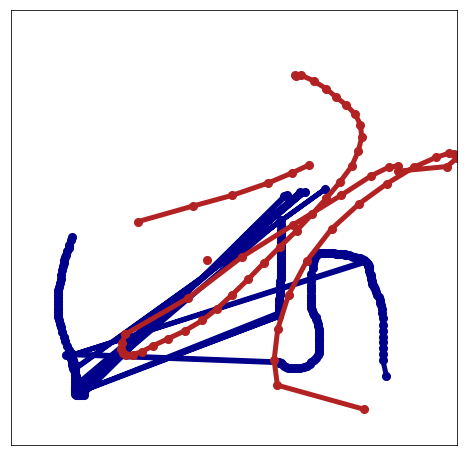

In [140]:
length = 100
# t = random.randint(0,len(microjam_corpus)-length)
t = 1000
mixture_temp = 1.5
sigma_temp = 0.01
ex =  random.choice(corpus) #microjam_corpus[t:t+length]  #sequences[600] 

decoder.reset_states()
p = condition_and_generate(decoder, ex, NUMBER_MIXTURES, temp=mixture_temp, sigma_temp=sigma_temp)
plot_double_2d(perf_array_to_df(ex), perf_array_to_df(p))

We can also generate unconditioned performances from a random starting point.

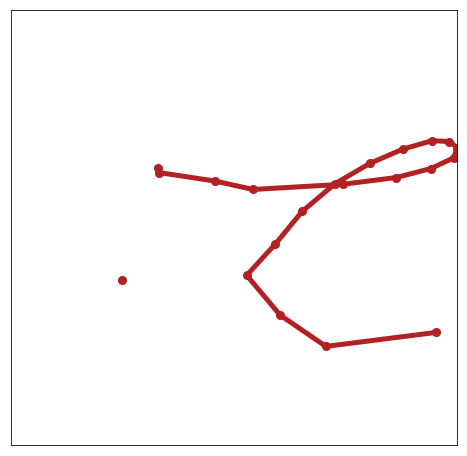

In [152]:
decoder.reset_states()
mixture_temp = 1.5
sigma_temp = 0.01
t = random_touch()
p = generate_random_tiny_performance(decoder, NUMBER_MIXTURES, t, temp=mixture_temp, sigma_temp=sigma_temp)
plot_2D(perf_array_to_df(p))